# UTAK:n raportti sopeuttamisen vaikutuksista

UTAK on julkaissut [raportin](https://utak.fi/wp-content/uploads/2025/04/Report-2025-04-v2.1-Web.pdf), jonka mukaan hallituksen sopeutukset paitsi epäonnistuisivat taittamaan velkasuhdetta, itse asiassa pahentaisivat sitä, kun verrataan tilanteeseen jossa mitään sopeutusta ei tehdä.

Raportti käyttää simulointiin [Bruegelin tuottamaa mallia](https://github.com/lennardwelslau/eu-debt-sustainability-analysis), jolla voidaan toistaa komission velkakestävyysanalyysi. UTAK:n teesi on, että komission laskuissaan käyttämä fipo-kerroin (0.75) on liian matala ja kerroinvaikutuksen kesto (3 vuotta) liian lyhyt. Raportissa lasketaan analyysit kertoimella 1.4 sekä kestoilla 5 tai 10 vuotta. Lisäksi huomioidaan maiden väliseen kauppaan liittyviä heijastusvaikutuksia. Jos ymmärrän oikein, tässä on kyse siitä, että sopeuttava maa aiheuttaa haittoja _kauppakumppaniensa_ bruttokansantuotteeseen fipo-kertoimen mukaisesti (esimerkiksi: jos Saksa vie tuotteita Suomeen, ja Suomi sopeuttaa, niin Saksan BKT kärsii).

Yritän tässä toistaa saatuja tuloksia sekä arvioida, miten paljon kukin tekijä vaikuttaa tuloksiin. Heijastusvaikutukset ovat käsittääkseni UTAK:n oma laajennus malliin, eivätkä löydy Bruegelin mallista. Niitä en siis laske.

In [1]:
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from classes import StochasticDsaModel as DSA
from classes import GroupDsaModel as GroupDSA
from functions import *

In [2]:
class Run:
    def __init__(self, annual_consolidation = 0.43, fiscal_multiplier = 0.75, fiscal_multiplier_persistence = 3): 
        self.annual_consolidation = annual_consolidation
        self.fiscal_multiplier = fiscal_multiplier
        self.fiscal_multiplier_persistence = fiscal_multiplier_persistence
        self.model = self._build_model()
        self.y, self.df = self._project()

    @property
    def d(self):
        return self.df.d.to_numpy()

    @property
    def output_gap(self):
        return self.df.output_gap.to_numpy()

    @property
    def dd(self):
        return self.d[1:] - self.d[:-1]
        
    @property
    def kstyle(self):
        return self._style(
            self.fiscal_multiplier,
            [(1.80, "teal", "$m \\geq 1.80$"),
             (1.40, "forestgreen", "$m \\geq 1.40$"),
             (1.00, "goldenrod", "$m \\geq 1.00$"),
             (0.75, "firebrick", "$m \\geq 0.75$")],
            0.20)
    
    @property
    def nstyle(self):
        return self._style(
            self.fiscal_multiplier_persistence,
            [(15, "teal", "15+ vuotta"),
             (10, "forestgreen", "10+ vuotta"),
             (5, "goldenrod", "5+ vuotta"),
             (3, "firebrick", "3+ vuotta")],
            0.04)

    def _style(self, x, opts, k):
        if self.annual_consolidation == 0:
            return {"color": "black", "label": "ei sopeutusta"}
        for limit, color, label in opts:
            if np.abs(x - limit) < 1e-3:
                return {"color": color, "alpha": 1.0, "label": label}
            elif x > limit:
                return {"color": color, "alpha": 0.40 - k * (x - limit)}
            else:
                continue
        return {"color": "magenta"}

    def _build_model(self):
        return DSA(
            country = "FIN",
            start_year = 2024,
            end_year = 2070,
            adjustment_period = 7,
            adjustment_start_year = 2025,
            ageing_cost_period = 99,
            fiscal_multiplier = self.fiscal_multiplier,
            fiscal_multiplier_persistence = self.fiscal_multiplier_persistence,
            fiscal_multiplier_type = "ec",
            bond_data = False,
        )

    def _project(self):
        years = np.array(list(range(self.model.start_year, self.model.end_year + 1)))
        self.model.project(self.annual_consolidation * self.model.adjustment_period)
        return years, self.model.df(all=True)

In [3]:
class Fan:
    def __init__(self, kk, nn):
        if isinstance(kk, Iterable):
            self.styleattr = "kstyle"
            nn = [nn]
        elif isinstance(nn, Iterable):
            self.styleattr = "nstyle"
            kk = [kk]
        else:
            raise RuntimeError("Bad config")
        
        self._runs = []
        self._runs.append(Run(0))
        for k in kk:
            for n in nn:
                self._runs.append(Run(0.43, k, n))

    def plot(self, ax, ymax, attr="d"):
        ymin = 2024
        iend = ymax - ymin + 1
        for run in self._runs:
            v = getattr(run, attr)
            style = getattr(run, self.styleattr)
            ax.plot(run.y[:iend], v[:iend], **style)
        ax.set_xlim(ymin, ymax)
        ax.legend()

## Fipo-kertoimen ja keston vaikutukset erikseen

Miten paljon finanssipoliittinen kerroin (tässä $m$) yksinään vaikuttaa velkasuhteen kehitykseen? Entä kerroinvaikutuksen kesto vuosissa?

Vasemmassa kuvaajassa tumma vihreä viiva vastaa kerrointa 1.4; oikeassa kuvaajassa tumma keltainen viiva vastaa 5 vuoden ja tumma vihreä viiva 10 vuoden kestoaikaa kertoimelle. Nämä ovat UTAK:n käyttämät parametrit.

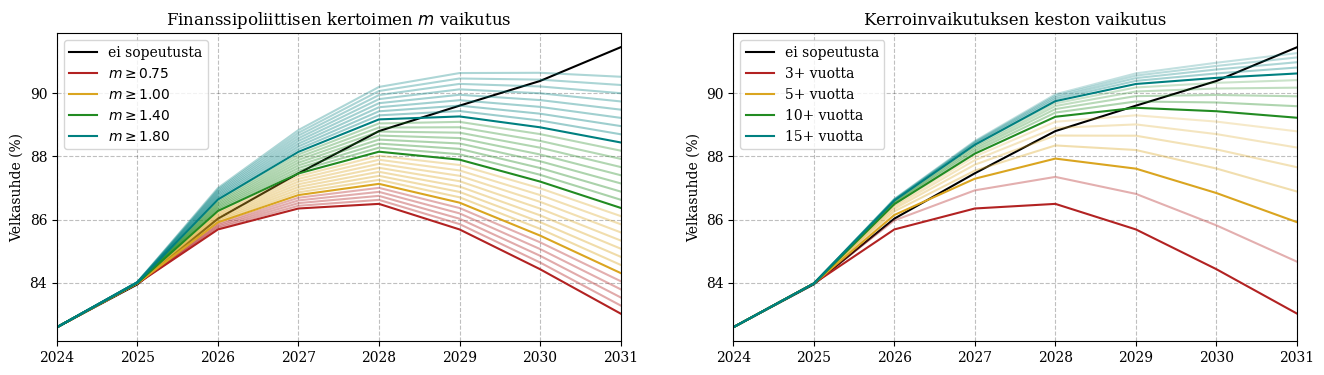

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title(f"Finanssipoliittisen kertoimen $m$ vaikutus")
ax[0].set_ylabel("Velkasuhde (%)")
fan = Fan(np.arange(0.75, 2.20, 0.05), 3)
fan.plot(ax[0], 2031)

ax[1].set_title(f"Kerroinvaikutuksen keston vaikutus")
ax[1].set_ylabel("Velkasuhde (%)")
fan = Fan(0.75, np.arange(3, 20, 1))
fan.plot(ax[1], 2031)

plt.savefig("fipo1.png", dpi=150, bbox_inches="tight")
plt.show()

## Yhdistetty vaikutus

Miten paljon fipo-kerroin ja kestoaika yhdessä vaikuttavat?

Tumma vihreä viiva vastaa vasemmassa kuvaajassa UTAK:n maltilliseksi kutsumaa laskelmaa, oikeassa sen realistiseksi kutsumaa laskelmaa.

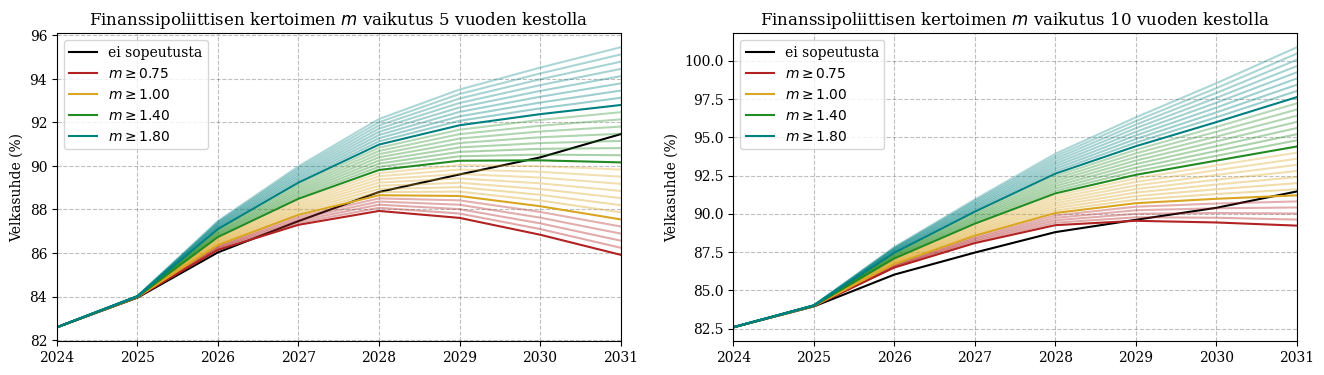

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title(f"Finanssipoliittisen kertoimen $m$ vaikutus 5 vuoden kestolla")
ax[0].set_ylabel("Velkasuhde (%)")
fan = Fan(np.arange(0.75, 2.20, 0.05), 5)
fan.plot(ax[0], 2031)

ax[1].set_title(f"Finanssipoliittisen kertoimen $m$ vaikutus 10 vuoden kestolla")
ax[1].set_ylabel("Velkasuhde (%)")
fan = Fan(np.arange(0.75, 2.20, 0.05), 10)
fan.plot(ax[1], 2031)

plt.savefig("fipo2.png", dpi=150, bbox_inches="tight")
plt.show()

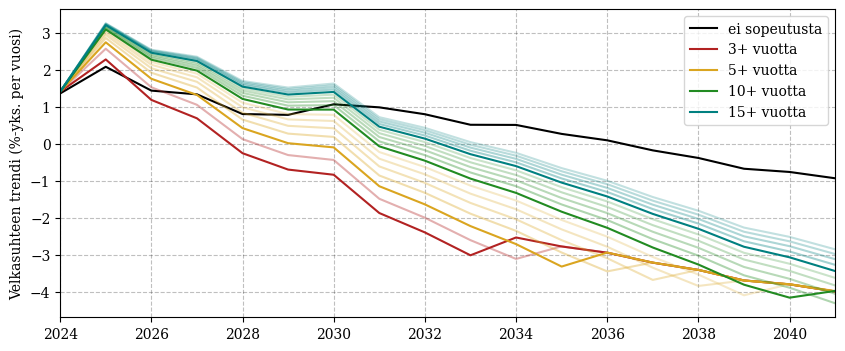

In [6]:
fig = plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.set_ylabel("Velkasuhteen trendi (%-yks. per vuosi)")
#ax.set_title("Tuotantokuilun muoto ja syvyys riippuu kerroinvaikutuksen (x1.40) kestosta.")
fan = Fan(1.40, np.arange(3, 20, 1))
fan.plot(ax, 2041, "dd")
plt.savefig("dd.png", dpi=150, bbox_inches="tight")

# Heijastusvaikutukset?

Prujusta silmämääräisesti arvioiden näyttäisi siltä, että UTAK:n laskemmissa velkasuhde saavuttaa vuonna 2031 arvon:

* **93.6** ns. maltillisessa skenaariossa;
* **100.7** ns. realistisessa skenaariossa.

Tässä tiedostossa lasketut skenaariot, joissa heijastusvaikutuksia ei ole huomioitu, tuottavat seuraavia arvoja:

In [7]:
def report(m, n):
    print(f"m={m:.2f} n={n:>2}: {Run(0.43, m, n).d[7]:.3f}")

report(0.75, 3)
report(0.75, 5)
report(0.75, 10)

report(1.40, 3)
report(1.40, 5)
report(1.40, 10)

m=0.75 n= 3: 83.021
m=0.75 n= 5: 85.918
m=0.75 n=10: 89.228
m=1.40 n= 3: 86.372
m=1.40 n= 5: 90.165
m=1.40 n=10: 94.402


Kaksi viimeistä riviä vastaavat UTAK:n skenaarioita ilman heijastusvaikutuksia.

Voimme laskea, että noin kolmannes löydetystä erosta komission velkakestävyysanalyysiin on peräisin heijastusvaikutuksista.

In [8]:
print((93.6 - 90.165) / (93.6 - 83.021))
print((100.7 - 94.402) / (100.7 - 83.021))

0.3246998771150383
0.35624186888398673
